# Datasets Overview

This project utilizes five datasets from Kaggle, providing comprehensive information on popular streaming platforms and IMDb ratings. Each dataset is updated daily, ensuring accurate and relevant content.

1. **Netflix**

    * Source: [Netflix Movies & TV Series Dataset](https://www.kaggle.com/datasets/octopusteam/full-netflix-dataset)
    * **Description**: A complete collection of Netflix's available titles (movies and TV series) with IMDb-specific data such as IMDb ID, average rating, and number of votes.

2. **Apple TV+**

    * Source: [Full Apple TV+ Dataset](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset)
    * Description: A dataset covering all Apple TV+ titles, including key IMDb data for in-depth analysis of content quality.

3. **HBO Max**

    * Source:  [Full HBO Max Dataset](https://www.kaggle.com/datasets/octopusteam/full-hbo-max-dataset)
    * Description: An extensive collection of titles on HBO Max with associated IMDb data for comparison.

3. **Amazon Prime**

   * Source: [Full Amazon Prime Dataset](https://www.kaggle.com/datasets/octopusteam/full-amazon-prime-dataset)
    * Description: Comprehensive data on Amazon Prime's movie and TV series offerings, including IMDb-specific metrics.

4. **Hulu**

    * Source: [Full Hulu Dataset](https://www.kaggle.com/datasets/octopusteam/full-hulu-dataset)
    * Description: A dataset detailing Hulu's catalog with IMDb-related columns for evaluating content quality and popularity.

Each of the streaming platform datasets includes the following columns:

* **title**: Name of the content.
* **type**: Either "movie" or "tv series."
* **genres**: Genres associated with the title.
* **releaseYear**: Year the title was released.
* **imdbId**: Unique IMDb identifier.
* **imdbAverageRating**: Average user rating on IMDb.
* **imdbNumVotes**: Number of votes received on IMDb.
* **availableCountries**: Countries where the title is available.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


### Load Datasets

In [2]:
# Define the base path
base_path = r"C:\Users\kimbe\Documents\StreamingAnalysis\data\raw_data"

# Load the datasets
amazon_df = pd.read_csv(f'{base_path}\\amazon_catalog.csv')
hulu_df = pd.read_csv(f'{base_path}\\hulu_catalog.csv')
netflix_df = pd.read_csv(f'{base_path}\\netflix_catalog.csv')
hbo_df = pd.read_csv(f'{base_path}\\hbo_catalog.csv')
apple_df = pd.read_csv(f'{base_path}\\apple_catalog.csv')

basics_df = pd.read_csv(f"{base_path}\\imdb_basics.csv", low_memory=False)
ratings_df = pd.read_csv(f"{base_path}\\imdb_ratings.csv", low_memory=False)

# Platform Info
platforms = ['Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple']
platform_dfs = [amazon_df, hulu_df, netflix_df, hbo_df, apple_df]


### Custom Functions

In [3]:
def clean_and_analyze_df(df):
    # Print row count before cleaning
    print(f"Row count before cleaning: {len(df)}")
    df.replace('\\N', np.nan, inplace=True)

    # Check if 'imdbId' exists in the DataFrame
    if 'imdbId' in df.columns:
        # Trim white spaces in 'imdbId' column
        df.loc[:, 'imdbId'] = df['imdbId'].str.strip()  # Use .loc to avoid SettingWithCopyWarning

        # Display duplicate imdbIds
        duplicate_imdb_ids = df[df.duplicated(subset=['imdbId'], keep=False)]
        if not duplicate_imdb_ids.empty:
            print("Duplicate imdbIds found:")
            print(duplicate_imdb_ids[['imdbId', 'title']])  # Display duplicate imdbIds with titles

        # Display rows with missing imdbId
        missing_imdb_ids = df[df['imdbId'].isna()]
        if not missing_imdb_ids.empty:
            print("Rows with missing imdbId found:")
            print(missing_imdb_ids[['imdbId', 'title']])  # Display rows with missing imdbIds

        # Remove rows with missing imdbId and duplicates
        df.dropna(subset=['imdbId'], inplace=True)  # Remove rows with missing imdbId
        df.drop_duplicates(subset=['imdbId'], keep='first', inplace=True)  # Keep only first occurrence of duplicates

    # Print row count after cleaning
    print(f"Row count after cleaning: {len(df)}")

    return df



Display a table with the column name, datatype, a random non-null value, and the number of missing values for each column

In [4]:
def summarize_columns(df):
    summary = []
    for column in df.columns:
        column_dtype = df[column].dtype
        
        # Find a random row with no null values
        non_null_rows = df.dropna()
        random_row = non_null_rows.sample(1).iloc[0]
        random_non_null_value = random_row[column]

        missing_values_count = df[column].isnull().sum()
        summary.append([column, column_dtype, random_non_null_value, missing_values_count])

    summary_df = pd.DataFrame(summary, columns=['Column Name', 'Data Type', 'Random Non-Null Value', 'Missing Values Count'])
    return summary_df

Print unique values in the dataset and number of them

In [5]:
def print_unique_values(df, column_name):
    """Prints all unique values in a specified column of a DataFrame.

    Args:
        df: The DataFrame to analyze.
        column_name: The name of the column to check.
    """
    unique_values = df[column_name].unique()
    print(f"Unique values in column '{column_name}':")
    print(unique_values)

Drop rows without US but first count and store the numbers

In [6]:
def availability_split(datasets, platforms):
    availability_data = []
    cleaned_datasets = {}  # To store cleaned datasets
    
    for platform, df in zip(platforms, datasets):
        # Count rows with "US"
        us_rows = df[df['availableCountries'].str.contains('US', na=False)]
        non_us_rows = df[~df['availableCountries'].str.contains('US', na=False)]
        
        # Calculate percentages
        total_rows = len(df)
        us_count = len(us_rows)
        non_us_count = len(non_us_rows)
        us_percentage = (us_count / total_rows) * 100 if total_rows > 0 else 0
        non_us_percentage = (non_us_count / total_rows) * 100 if total_rows > 0 else 0
        
        # Store availability data
        availability_data.append({
            'platform': platform,
            'us_count': us_count,
            'us_percentage': us_percentage,
            'non_us_count': non_us_count,
            'non_us_percentage': non_us_percentage
        })
        
        # Save the cleaned dataset for this platform
        cleaned_datasets[platform] = us_rows.reset_index(drop=True)
    
    # Create a DataFrame for availability data
    availability_df = pd.DataFrame(availability_data)
    
    # Create the plot with better styling
    plt.figure(figsize=(14, 8))  # Increase figure size for better readability
    
    # Plot stacked bar chart
    ax = availability_df.plot(kind='bar', x='platform', y=['us_percentage', 'non_us_percentage'], stacked=True,
                              color=['#4C8BF5', '#FF6F61'], width=0.75, edgecolor='white', legend=True)

    # Add titles and labels
    plt.title('Content Availability: U.S. vs Non-U.S. for Each Platform', fontsize=18, weight='bold', color='#333')
    plt.xlabel('Platform', fontsize=14, color='#555')
    plt.ylabel('Percentage of Titles', fontsize=14, color='#555')

    # Customize x-axis tick labels
    plt.xticks(rotation=45, ha='right', fontsize=12, color='#555')

    # Add data labels inside each section of the bars
    for p in ax.patches:
        # Get the height and position of each section
        height = p.get_height()
        width = p.get_width()
        x = p.get_x() + width / 2
        y = p.get_y() + height / 2
        
        # Annotate only the US and Non-US percentages inside the bars
        ax.annotate(f'{height:.1f}%', (x, y), ha='center', va='center', fontsize=11, color='white', fontweight='bold')

    # Adjust the legend position inside the plot (in the upper-right corner)
    ax.legend(['US Content', 'Non-US Content'], loc='upper left', fontsize=12)

    # Adjust layout to make sure everything fits (including title and legend)
    plt.tight_layout()

    # Optionally remove gridlines or use more subtle ones
    ax.grid(False)  # Remove gridlines for a cleaner look

    # Save the plot as a PNG file
    plt.savefig(r'C:\Users\kimbe\Documents\StreamingAnalysis\outputs\us_availability.png', dpi=300)
    print("Saved content availability visualization as PNG.")
    plt.show
    return cleaned_datasets


Add a new column with the platform name and fill with 1

In [7]:
# Define the function to add the platform-specific column
def add_platform_column(df, platform_name):
    df[platform_name] = 1  # Mark all rows as available in the platform
    return df

Merge platform datasets on imdbId and handle NaN for availability

In [8]:

# Function to merge platform datasets on imdbId and handle NaN for availability
def merge_platform_datasets(platforms, platform_dfs):
    
    # Combine all datasets into a single dataframe
    all_platforms = pd.concat(platform_dfs, ignore_index=True)
    
    # Perform the groupby operation with custom aggregation logic
    merged_df = all_platforms.groupby('imdbId', as_index=False).agg({
        'type': 'first',        # Take the first non-null value
        'genres': 'first',      # Take the first non-null value
        'releaseYear': 'first', # Take the first non-null value
        'title': 'first',       # Take the first non-null value
        'imdbAverageRating': 'first',
        'imdbNumVotes': 'first',
        **{platform: 'max' for platform in platforms}  # Max will consolidate availability across datasets
    })
    
    # Replace NaN values in platform-specific columns with 0 and ensure binary representation (0 or 1)
    for platform in platforms:
        merged_df[platform] = merged_df[platform].fillna(0).astype(int)  # Modify directly and assign
    
    return merged_df

Count missing values with percentages

In [9]:
def count_missing_values(df):
    # Calculate missing values and percentages
    missing_counts = df.isnull().sum()
    missing_percentage = (df.isnull().mean() * 100).round(2)
    
    # Create the summary DataFrame
    missing_summary = pd.DataFrame({
        'Missing Values': missing_counts,
        'Percentage (%)': missing_percentage.astype(str) + '%'
    })
    
    return missing_summary

# Combine Platforms

In [10]:
platform_dfs = [amazon_df, hulu_df, netflix_df, hbo_df, apple_df]

# Clean and analyze each platform dataset - Remove Whitespace, Drop rows w/o imdbId, Remove imdbId dupes
cleaned_datasets = [clean_and_analyze_df(df) for df in platform_dfs]

# Reassign cleaned datasets back to their respective variables:
amazon_df, hulu_df, netflix_df, hbo_df, apple_df = cleaned_datasets

Row count before cleaning: 67912
Duplicate imdbIds found:
          imdbId                                  title
855    tt0072547                     Moses the Lawgiver
3313         NaN                                  Turbo
3385   tt0346946                                Ferrari
3907         NaN  Crusty Demons 14: A Bloodthirsty Saga
4368         NaN       The Wiggles: Live: Hot Potatoes!
...          ...                                    ...
67903        NaN                                    NaN
67904        NaN                                    NaN
67907        NaN                                    NaN
67908        NaN                                    NaN
67910        NaN                                    NaN

[5773 rows x 2 columns]
Rows with missing imdbId found:
      imdbId                                  title
3313     NaN                                  Turbo
3907     NaN  Crusty Demons 14: A Bloodthirsty Saga
4368     NaN       The Wiggles: Live: Hot Potatoes!
4810 

In [11]:
# Check shape of all platform df
# Sum the number of rows in all DataFrames within platform_dfs
total_rows = sum(len(dataset) for dataset in platform_dfs)

# Print the total number of rows
print(f"Total number of rows across all raw datasets: {total_rows}")

Total number of rows across all raw datasets: 113511


Remove rows where not in US, count and save to csv

Saved content availability visualization as PNG.


<Figure size 1400x800 with 0 Axes>

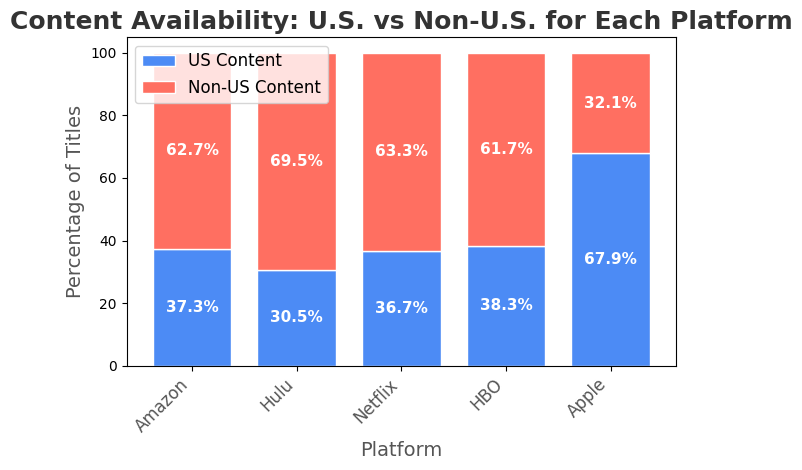

In [12]:
# Call the function
cleaned_datasets = availability_split(platform_dfs, platforms)


In [13]:
# Extract updated platforms and their corresponding DataFrames
platforms = list(cleaned_datasets.keys())  # Extract keys (platform names) from the dictionary
platform_dfs = list(cleaned_datasets.values())  # Extract values (U.S.-only DataFrames) from the dictionary

# Reassign updated DataFrames to original variables
for platform, df in zip(platforms, platform_dfs):
    if platform == "Amazon":
        amazon_df = df
    elif platform == "Hulu":
        hulu_df = df
    elif platform == "Netflix":
        netflix_df = df
    elif platform == "HBO":
        hbo_df = df
    elif platform == "Apple":
        apple_df = df

# Verify the update
print("Updated Platforms:", platforms)
print(f"Number of Updated DataFrames: {len(platform_dfs)}")
for platform, df in zip(platforms, platform_dfs):
    print(f"{platform}: {len(df)} rows")


Updated Platforms: ['Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple']
Number of Updated DataFrames: 5
Amazon: 23178 rows
Hulu: 2731 rows
Netflix: 6935 rows
HBO: 2616 rows
Apple: 11323 rows


In [14]:
# Check shape of platform datasets
# Sum the number of rows in all DataFrames within platform_dfs
total_rows = sum(len(dataset) for dataset in platform_dfs)

# Print the total number of rows
print(f"Total number of rows across all US datasets: {total_rows}")

Total number of rows across all US datasets: 46783


Add a new column with the platform name and fill with 1

In [15]:
# Apply the function for each platform dataset
for platform_name, df in zip(platforms, platform_dfs):
    # Update the DataFrame by assigning the result back to the variable
    idx = platforms.index(platform_name)  # Get the index of the platform
    platform_dfs[idx] = add_platform_column(df, platform_name)

In [16]:
# Check that it worked
summarize_columns(netflix_df)

,Column Name,Data Type,Random Non-Null Value,Missing Values Count
0,title,object,Boca Juniors Confidential,0
1,type,object,tv,0
2,genres,object,"Drama, Music",1
3,releaseYear,float64,2022.0,0
4,imdbId,object,tt13978306,0
5,imdbAverageRating,float64,5.6,34
6,imdbNumVotes,float64,1128.0,34
7,availableCountries,object,"AE, AG, AL, AO, AR, AU, AZ, BA, BB, BG, BH, BM...",0
8,Netflix,int64,1,0


Merge the platforms on imdbId

In [17]:
# Merge the datasets
platform_merged = merge_platform_datasets(platforms, platform_dfs)

In [18]:
# Clean and analyze each platform dataset - Remove Whitespace, Drop rows w/o imdbId, Remove imdbId dupes
platform_merged = clean_and_analyze_df(platform_merged)

# Display cleaned DataFrame information
summarize_columns(platform_merged)


Row count before cleaning: 44560
Row count after cleaning: 44560


,Column Name,Data Type,Random Non-Null Value,Missing Values Count
0,imdbId,object,tt13080774,0
1,type,object,movie,0
2,genres,object,"Drama, Romance, Thriller",144
3,releaseYear,float64,2022.0,3
4,title,object,Laakhon Mein Ek,0
5,imdbAverageRating,float64,6.2,813
6,imdbNumVotes,float64,181.0,813
7,Amazon,int64,1,0
8,Hulu,int64,0,0
9,Netflix,int64,0,0


In [19]:
# Sum of each platform column
platform_sums = platform_merged[['Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple']].sum()

# Print the sum for each platform
print(platform_sums)


Amazon     23178
Hulu        2731
Netflix     6935
HBO         2616
Apple      11323
dtype: int64


Remove release year where outside of 1898 - 2024

In [20]:
platform_merged = platform_merged[(platform_merged['releaseYear'] >= 1898) & (platform_merged['releaseYear'] <= 2024)]

In [21]:
# Print the total number of rows
print(f"Total number of rows across all US datasets after incorrect years removed: {platform_merged.shape[0]}")

Total number of rows across all US datasets after incorrect years removed: 44554


Extract imdbIds

Merge the imbd info datasets

In [22]:
# Merge the datasets on 'tconst'
imdb_info = pd.merge(basics_df, ratings_df, on='tconst', how='inner')

# Display the resulting DataFrame
print("Raw imdb:", imdb_info.shape)

imdb_info.rename(columns={"tconst": "imdbId", "primaryTitle": "title"}, inplace=True)


Raw imdb: (1506750, 11)


In [23]:
imdb_info = clean_and_analyze_df(imdb_info)

# Display cleaned DataFrame information
summarize_columns(imdb_info)


Row count before cleaning: 1506750
Row count after cleaning: 1506750


,Column Name,Data Type,Random Non-Null Value,Missing Values Count
0,imdbId,object,tt8591588,0
1,titleType,object,tvSeries,0
2,title,object,The Guardians,1
3,originalTitle,object,Something for the Weekend,1
4,isAdult,object,0,0
5,startYear,object,2021,246
6,endYear,object,2001,1448495
7,runtimeMinutes,object,40,450199
8,genres,object,Talk-Show,21466
9,averageRating,float64,7.1,0


In [24]:
print("Platforms merged shape:", platform_merged.shape)

Platforms merged shape: (44554, 12)


In [25]:
count_missing_values(platform_merged)

,Missing Values,Percentage (%)
imdbId,0,0.0%
type,0,0.0%
genres,144,0.32%
releaseYear,0,0.0%
title,0,0.0%
imdbAverageRating,807,1.81%
imdbNumVotes,807,1.81%
Amazon,0,0.0%
Hulu,0,0.0%
Netflix,0,0.0%


In [26]:
# Merge platform_merged with imdb_info on 'imdbId' using a left join
final_df = platform_merged.merge(imdb_info, on='imdbId', how='left')

# Check the shape of the resulting DataFrame
print("Merged DataFrame shape:", final_df.shape)



Merged DataFrame shape: (44554, 22)


### Investigate missing values

In [27]:
final_df = clean_and_analyze_df(final_df)


Row count before cleaning: 44554
Row count after cleaning: 44554


In [28]:
count_missing_values(final_df)

,Missing Values,Percentage (%)
imdbId,0,0.0%
type,0,0.0%
genres_x,144,0.32%
releaseYear,0,0.0%
title_x,0,0.0%
imdbAverageRating,807,1.81%
imdbNumVotes,807,1.81%
Amazon,0,0.0%
Hulu,0,0.0%
Netflix,0,0.0%


Platform sums before cleaning:
Amazon     23173
Hulu        2731
Netflix     6935
HBO         2615
Apple      11321
dtype: int64


C:\Users\kimbe\AppData\Local\Temp\ipykernel_8680\182921817.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


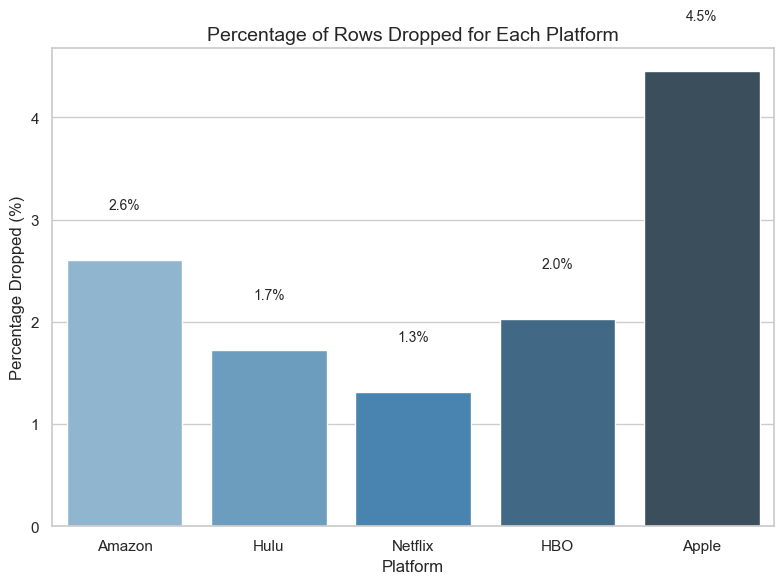

In [29]:
# Keep track of platform sums before cleaning
platform_sums_before = final_df[['Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple']].sum()
print("Platform sums before cleaning:")
print(platform_sums_before)

# Drop originalTitle, endYear, isAdult, runtimeMinutes, genres_y
columns_to_drop = ['originalTitle', 'endYear', 'isAdult', 'runtimeMinutes', 'genres_y']
final_df.drop(columns=columns_to_drop, inplace=True)

# Drop rows where genres_x is blank
final_df = final_df[final_df['genres_x'].notna() & (final_df['genres_x'] != "")]

#Drop rows where titleType is "tvEpisode"
final_df = final_df[final_df['titleType'] != "tvEpisode"]


# Change type based on titleType
title_type_to_type = {
    "short": "movie",
    "tvMiniSeries": "tv",
    "tvMovie": "movie",
    "tvSeries": "tv",
    "tvShort": "movie",
    "tvSpecial": "movie",
    "video": "movie"
}

final_df['type'] = final_df['titleType'].replace(title_type_to_type)


# Drop additional columns
columns_to_drop = ['startYear', 'titleType', 'title_y']
final_df.drop(columns=columns_to_drop, inplace=True)

# Drop rows where imdbAverageRating is blank or NaN
final_df = final_df[final_df['imdbAverageRating'].notna()]

# Drop additional columns
columns_to_drop = ['averageRating', 'numVotes']
final_df.drop(columns=columns_to_drop, inplace=True)

# Calculate sum of each platform after cleaning
platform_sums_after = final_df[['Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple']].sum()

# Calculate the number of rows dropped for each platform
platform_dropped_counts = platform_sums_before - platform_sums_after

# Calculate the percentage of rows dropped for each platform
platform_dropped_percent = (platform_dropped_counts / platform_sums_before) * 100

# Convert to a DataFrame for easier plotting
platform_dropped_percent_df = platform_dropped_percent.reset_index()
platform_dropped_percent_df.columns = ['Platform', 'Percentage Dropped']

# Set Seaborn style
sns.set_theme(style="whitegrid", palette="pastel")

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    x='Platform',
    y='Percentage Dropped',
    data=platform_dropped_percent_df,
    palette="Blues_d"
)

# Add labels and title
plt.title('Percentage of Rows Dropped for Each Platform', fontsize=14)
plt.ylabel('Percentage Dropped (%)', fontsize=12)
plt.xlabel('Platform', fontsize=12)

# Show values on top of bars
for i, row in platform_dropped_percent_df.iterrows():
    plt.text(
        i, 
        row['Percentage Dropped'] + 0.5,  # Position above the bar
        f"{row['Percentage Dropped']:.1f}%",  # Format percentage
        ha='center', 
        fontsize=10
    )

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
count_missing_values(final_df)

,Missing Values,Percentage (%)
imdbId,0,0.0%
type,12,0.03%
genres_x,0,0.0%
releaseYear,0,0.0%
title_x,0,0.0%
imdbAverageRating,0,0.0%
imdbNumVotes,0,0.0%
Amazon,0,0.0%
Hulu,0,0.0%
Netflix,0,0.0%


In [31]:
# Rename Columns
final_df.rename(columns={'genres_x': 'genres'}, inplace=True)
final_df.rename(columns={'title_x': 'title'}, inplace=True)
final_df.rename(columns={'imdbAverageRating': 'rating'}, inplace=True)
final_df.rename(columns={'imdbNumVotes': 'numVotes'}, inplace=True)

In [32]:
# Dictionary to map IMDb IDs to their corrected types
imdb_id_type_correction = {
    "tt0101037": "movie",
    "tt14791494": "movie",
    "tt22297698": "movie",
    "tt22814400": "tv",
    "tt29634610": "movie",
    "tt30495748": "tv",
    "tt32132269": "tv",
    "tt32482847": "tv",
    "tt33356012": "tv",
    "tt4966036": "movie",
    "tt5556110": "movie",
    "tt8660842": "movie",
}

# Update the 'type' column in the dataset based on the mapping
final_df['type'] = final_df.apply(
    lambda row: imdb_id_type_correction[row['imdbId']] if row['imdbId'] in imdb_id_type_correction else row['type'], 
    axis=1
)

# Clean up final dataset

In [33]:
summarize_columns(final_df)

,Column Name,Data Type,Random Non-Null Value,Missing Values Count
0,imdbId,object,tt31608961,0
1,type,object,movie,0
2,genres,object,Drama,0
3,releaseYear,float64,1989.0,0
4,title,object,Wanted Man,0
5,rating,float64,5.5,0
6,numVotes,float64,62.0,0
7,Amazon,int64,0,0
8,Hulu,int64,0,0
9,Netflix,int64,0,0


Rename and change datatypes

In [34]:

# Correct datatypes
final_df['releaseYear'] = final_df['releaseYear'].astype(int)  
final_df['numVotes'] = final_df['numVotes'].astype(int)

In [35]:
# Rearrange columns in a more logical order
final_df = final_df[['imdbId', 'title', 'type', 'genres', 'releaseYear', 'rating', 'numVotes', 'Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple']]


In [36]:
# Convert the genres column to lists 
final_df['genres'] = final_df['genres'].str.split(',')

# Clean and sort each genre group to standardize representation
final_df['genres'] = final_df['genres'].apply(lambda x: [genre.strip() for genre in x] if isinstance(x, list) else [])

# Flatten the list of all genre groups into individual groups and count occurrences
all_genre_groups = final_df['genres'].apply(tuple)  # Convert to tuple for immutability
genre_group_counts = all_genre_groups.value_counts()

# Create a DataFrame with the unique genre groups and their counts
unique_genre_groups_df = pd.DataFrame({
    'Genre Group': ['/'.join(group) for group in genre_group_counts.index],
    'Count': genre_group_counts.values
})


In [37]:
# Define the file path
file_path = r"C:\Users\kimbe\Documents\StreamingAnalysis\data\cleaned_data\final_df.csv"

# Save the dataframe to a CSV file
final_df.to_csv(file_path, index=False)

One hot encode genres

In [38]:
# Standardize genres
genre_replacements = {
    'Reality': 'Reality-TV', 
    'Adult': None,  
    'Sci-Fi': 'Science Fiction', 
    'Action & Adventure': None,
    'Kids': None,
    'Soap': None,
    'Film Noir': None
}

# Apply the genre replacements to the genres column
final_df['genres'] = final_df['genres'].apply(lambda x: [genre_replacements.get(genre, genre) for genre in x])

# Remove any genres that were marked for removal (i.e., 'None')
final_df['genres'] = final_df['genres'].apply(lambda x: [genre for genre in x if genre is not None])

# Flatten the genres column and get the count of each unique genre
all_genres = final_df['genres'].explode().value_counts()

# Calculate the percentage
total_rows = len(final_df)
percentage = (all_genres / total_rows) * 100

# Combine the count and percentage into a DataFrame
genre_summary = pd.DataFrame({
    'count': all_genres,
    'percentage': percentage
}).reset_index()

# Rename columns for clarity
genre_summary.columns = ['genre', 'count', 'percentage']

# Display the result
print(genre_summary)


              genre  count  percentage
0             Drama  19091   44.110444
1            Comedy  11763   27.178835
2            Action   6676   15.425139
3       Documentary   6020   13.909427
4             Crime   5718   13.211645
5           Romance   5450   12.592421
6          Thriller   5427   12.539279
7            Horror   4417   10.205638
8         Adventure   4144    9.574861
9           Mystery   3264    7.541590
10           Family   2668    6.164510
11        Animation   2325    5.371996
12          Fantasy   1906    4.403882
13        Biography   1879    4.341497
14  Science Fiction   1634    3.775416
15          History   1602    3.701479
16       Reality-TV   1280    2.957486
17            Music   1148    2.652495
18          Western    914    2.111830
19            Sport    837    1.933919
20              War    694    1.603512
21            Short    465    1.074399
22          Musical    454    1.048983
23        Game-Show    250    0.577634
24        Film-Noir    11

Ready to hot encode

In [39]:
# Perform one-hot encoding on the 'genres' column
one_hot_encoded = final_df['genres'].explode().str.get_dummies().groupby(level=0).sum()

# Merge the one-hot encoded columns back into the original DataFrame
final_df = final_df.join(one_hot_encoded)

# Verify the changes
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 43280 entries, 0 to 44553
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdbId           43280 non-null  object 
 1   title            43280 non-null  object 
 2   type             43280 non-null  object 
 3   genres           43280 non-null  object 
 4   releaseYear      43280 non-null  int64  
 5   rating           43280 non-null  float64
 6   numVotes         43280 non-null  int64  
 7   Amazon           43280 non-null  int64  
 8   Hulu             43280 non-null  int64  
 9   Netflix          43280 non-null  int64  
 10  HBO              43280 non-null  int64  
 11  Apple            43280 non-null  int64  
 12  Action           43280 non-null  int64  
 13  Adventure        43280 non-null  int64  
 14  Animation        43280 non-null  int64  
 15  Biography        43280 non-null  int64  
 16  Comedy           43280 non-null  int64  
 17  Crime            

In [40]:
summarize_columns(final_df)

,Column Name,Data Type,Random Non-Null Value,Missing Values Count
0,imdbId,object,tt0069851,0
1,title,object,Sniper Corpse,0
2,type,object,movie,0
3,genres,object,[Comedy],0
4,releaseYear,int64,2020,0
5,rating,float64,5.9,0
6,numVotes,int64,7777,0
7,Amazon,int64,0,0
8,Hulu,int64,0,0
9,Netflix,int64,0,0


In [41]:
# Define the file path
file_path = r"C:\Users\kimbe\Documents\StreamingAnalysis\data\cleaned_data\final_df.csv"

# Save the dataframe to a CSV file
final_df.to_csv(file_path, index=False)

print(f"Data saved to {file_path}")


Data saved to C:\Users\kimbe\Documents\StreamingAnalysis\data\cleaned_data\final_df.csv
